In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)

        self.x = df.iloc[:, 12:17].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

        self.y = df.iloc[:, 7:8].values
        
        self.length = len(df)

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [3]:
dataset = CustomDataset("180801_RFB_510cy_006_DC.csv")
print(dataset.x.shape)
print(dataset.x.dtype)
print(dataset.y.shape)
print(dataset.y.dtype)

(262407, 5)
float64
(262407, 1)
float64


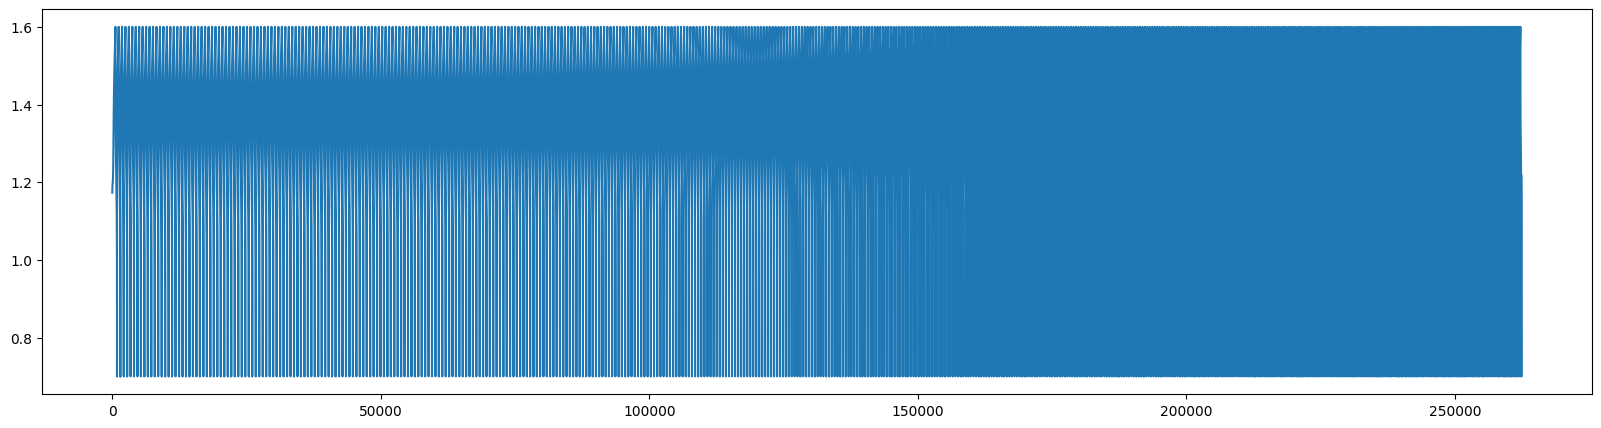

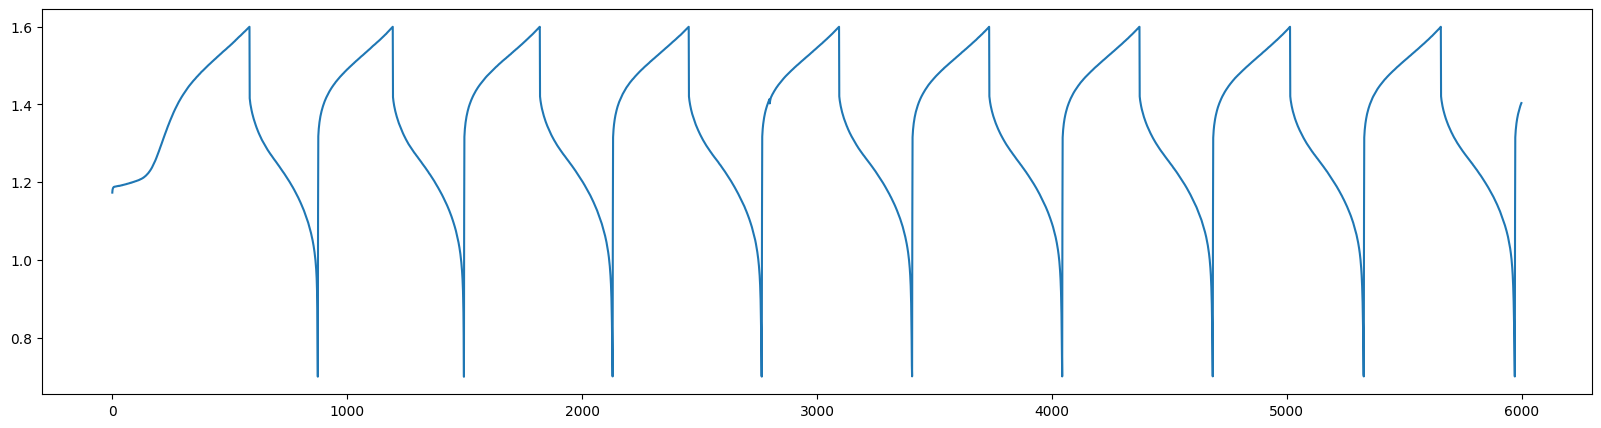

In [4]:
plt.figure(figsize=(20,5))
plt.plot(dataset.y)

plt.figure(figsize=(20,5))
plt.plot(dataset.y[:6000])
plt.show()

In [5]:
# X_train = X[:200000]
# X_test = X[200000:]

# y_train = y[:200000]
# y_test = y[200000:] 

# print(X_train.dtypes)
# print("Training Shape", X_train.shape, y_train.shape)
# print("Testing Shape", X_test.shape, y_test.shape) 

dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# X_train = X[:train_size]
# X_val = X[train_size:(train_size + validation_size)]
# X_test = X[(train_size + validation_size):(train_size + validation_size +test_size)]



print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 209925
Validation Data Size : 26240
Testing Data Size : 26242


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)

In [7]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.batchnormal = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes) 

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        
        output, (hn) = self.gru(x, (h_0)) 
        hn = hn.view(-1, self.hidden_size) 
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out)
        return out

In [8]:
num_epochs = 1000 
learning_rate = 0.01

input_size = 5 
hidden_size = 32
num_layers = 1 

num_classes = 1

model = GRU(num_classes, input_size, hidden_size, num_layers, dataset.x.shape[1])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
writer = SummaryWriter()

def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    for i, data in prog_bar:
        counter += 1
        data, target = data[0], data[1]
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [10]:
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0], data[1]
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [11]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    writer.add_scalar("Loss/train", train_epoch_loss, epoch)
    val_epoch_loss, val_epoch_accuracy = validate(
        model, validation_dataloader, validation_dataset, criterion
    )
    writer.add_scalar("Loss/val", val_epoch_loss, epoch)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if epoch % 100 == 0:
        print("Train Loss: %e, Train Acc: %.2f" %(train_epoch_loss, train_epoch_accuracy))
        print('Val Loss: %e, Val Acc: %.2f' %(val_epoch_loss, val_epoch_accuracy))
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

writer.flush()
writer.close()

Epoch 1 of 1000
Training


  0%|          | 0/820 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_32404\3594872476.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  feature = torch.FloatTensor([self.x[index]])
100%|██████████| 820/820 [00:04<00:00, 168.40it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1798.24it/s]


Train Loss: 1.015935e-02, Train Acc: 0.00
Val Loss: 1.575175e-04, Val Acc: 0.00
Epoch 2 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 174.02it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1964.01it/s]


Epoch 3 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 172.37it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1805.87it/s]


Epoch 4 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 173.44it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2080.51it/s]


Epoch 5 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 194.17it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2046.58it/s]


Epoch 6 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 181.58it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2040.35it/s]


Epoch 7 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 182.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1967.52it/s]


Epoch 8 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 183.36it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1729.96it/s]


Epoch 9 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 188.78it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2086.52it/s]


Epoch 10 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 188.33it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2051.62it/s]


Epoch 11 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 189.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2034.48it/s]


Epoch 12 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 193.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2078.44it/s]


Epoch 13 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 187.17it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2062.87it/s]


Epoch 14 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 189.96it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2073.31it/s]


Epoch 15 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 189.64it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2078.94it/s]


Epoch 16 of 1000
Training


100%|██████████| 820/820 [00:04<00:00, 169.28it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1757.77it/s]


Epoch 17 of 1000
Training


 21%|██        | 171/820 [00:01<00:03, 164.93it/s]

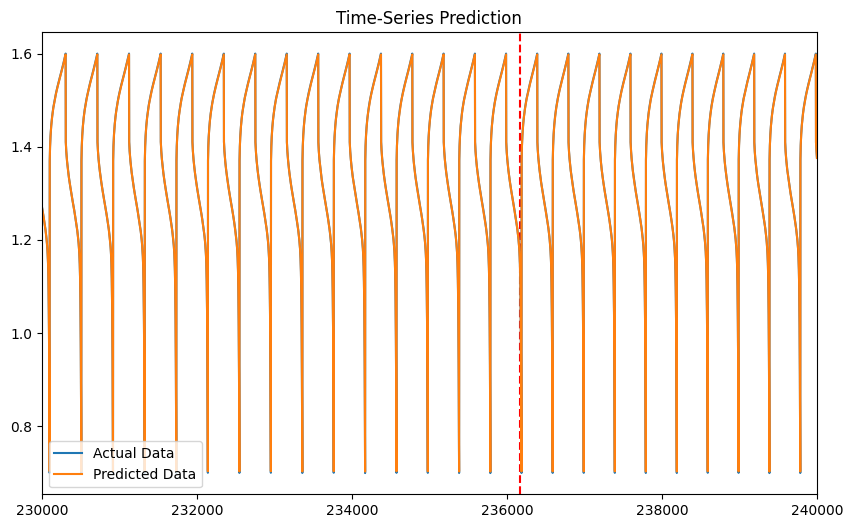

In [ ]:
df_x_ss = dataset.x
df_y_ms = dataset.y

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
label_y = df_y_ms.data.numpy()


plt.figure(figsize=(10,6)) 
plt.axvline(x=dataset_size-test_size, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.xlim([230000, 240000])
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

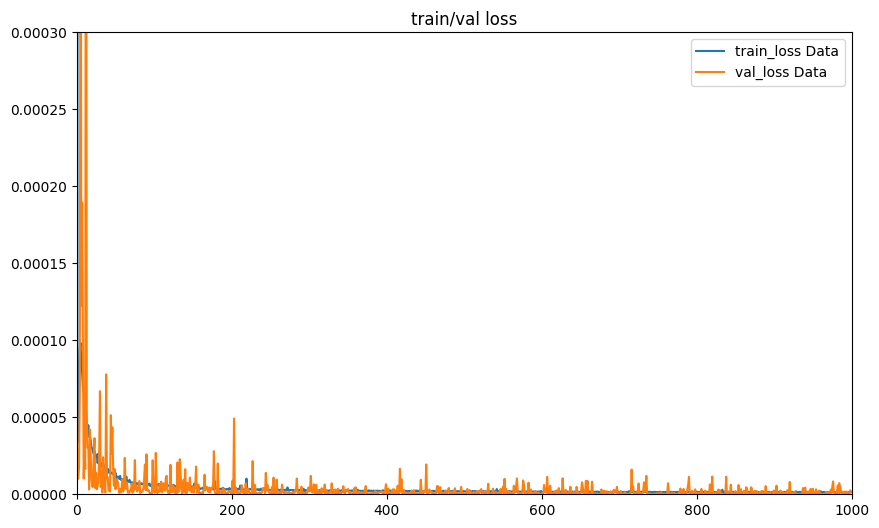

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(train_loss, label='train_loss Data')
plt.plot(val_loss, label='val_loss Data')
plt.title('train/val loss')
plt.xlim([0, 1000])
plt.ylim([0, 0.0003])
plt.legend()
plt.show()

In [ ]:
print("train_loss(990~1000) : ",np.mean(train_loss[990:1000]))
#print(np.mean(val_loss[990:1000]))

train_loss(990~1000) :  1.3669307559889644e-06
